In [1]:
import collections
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage import exposure
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import cv2
fontprops = fm.FontProperties(size=34)
from sklearn.neighbors import NearestNeighbors
from skimage import color, measure, filters
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import skimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import filters
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import gaussian
from skimage.filters.rank import median
from skimage.morphology import disk, ball
from collections import defaultdict



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [4]:
from config import *
import my_io as io

# Import metadata information

In [5]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

Pos Grades Stage                                         Directory
0  B1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1  B3      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2  B5      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3  C6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4  D7      3  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7

In [6]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [7]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


# Cell nuclei diamter analysis

In [8]:
def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_figure / 'mask_DL'

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'both' in name:
            continue
        elif ROI in name and 'nuclei' in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def get_cell_diamter(cell_mask):
    # Multiple each cell region by mean intensity 
    exp_prop = pd.DataFrame(measure.regionprops_table(cell_mask, properties=['label', 'major_axis_length', 'minor_axis_length'])).set_index('label')
    exp_prop = exp_prop.rename(columns = {'major_axis_length': 'Major', 'minor_axis_length': 'Minor'}, errors = 'raise')
    return exp_prop

In [9]:
df_diameter = []
for dataset in datasets:
    # Read image and cell_mask
#     cell_mask = read_cell_mask(dataset)
    cell_mask = io.read_nuclei_mask(dataset, data_nuclei)
    diameter = get_cell_diamter(cell_mask)
    diameter['Dataset'] = dataset
    df_diameter.append(diameter)
    
df = pd.concat(df_diameter)

df_length = df.iloc[:,:2]
df_length = df_length.melt(var_name='Axis', value_name='Length')

In [10]:
df[['Major', 'Minor']].describe()

Major         Minor
count  44379.000000  44379.000000
mean      11.586333      7.496925
std        4.049212      2.439002
min        5.089672      2.458772
25%        8.671434      5.654684
50%       10.670645      7.144563
75%       13.653943      8.819840
max       44.284191     22.708927

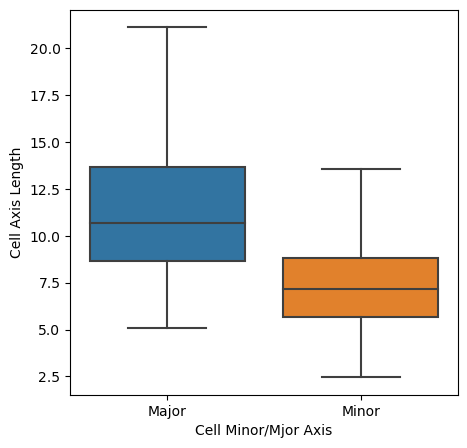

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(data=df_length, x='Axis', y='Length', showfliers=False)
ax.set(xlabel='Cell Minor/Mjor Axis', ylabel='Cell Axis Length')
plt.show()

# Cell diameter anaylsis

In [12]:
def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_figure / 'mask_DL'

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'both' in name:
            continue
        elif ROI in name and 'cyto' in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def get_cell_diamter(cell_mask):
    # Multiple each cell region by mean intensity 
    exp_prop = pd.DataFrame(measure.regionprops_table(cell_mask, properties=['label', 'major_axis_length', 'minor_axis_length'])).set_index('label')
    exp_prop = exp_prop.rename(columns = {'major_axis_length': 'Major', 'minor_axis_length': 'Minor'}, errors = 'raise')
    return exp_prop

In [13]:
df_diameter = []
for dataset in datasets:
    # Read image and cell_mask
#     cell_mask = read_cell_mask(dataset)
    cell_mask = io.read_cell_mask(dataset, data_ROI)
    diameter = get_cell_diamter(cell_mask)
    diameter['Dataset'] = dataset
    df_diameter.append(diameter)
    
df_cyto = pd.concat(df_diameter)

In [14]:
df_cyto[['Major', 'Minor']].describe()

Major         Minor
count  44379.000000  44379.000000
mean      14.903829     10.061539
std        4.241597      2.895167
min        5.215362      2.939694
25%       12.016885      7.982998
50%       14.253992      9.925395
75%       17.140357     11.877455
max       47.229617     25.886503

In [15]:
df_length_cyto = df_cyto.iloc[:,:2]
df_length_cyto = df_length_cyto.melt(var_name='Axis', value_name='Length')

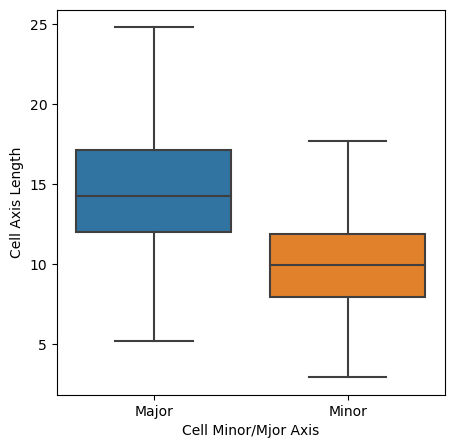

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(data=df_length_cyto, x='Axis', y='Length', showfliers=False)
ax.set(xlabel='Cell Minor/Mjor Axis', ylabel='Cell Axis Length')
plt.show()

In [17]:
df_diff = df_cyto[['Major', 'Minor']] - df[['Major', 'Minor']]
df_diff.describe()

Major         Minor
count  44379.000000  44379.000000
mean       3.317497      2.564614
std        1.868751      1.778981
min       -1.696130     -0.960882
25%        2.043866      1.046938
50%        3.419215      2.642844
75%        4.900710      3.817928
max        8.529817      7.284372

In [18]:
df_diff = df_diff.melt(var_name='Axis', value_name='Difference')

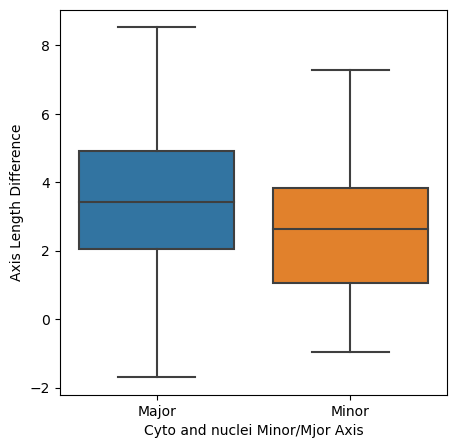

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(data=df_diff, x='Axis', y='Difference')
ax.set(xlabel='Cyto and nuclei Minor/Mjor Axis', ylabel='Axis Length Difference')
plt.show()

# Multiple Diameter value analysis for sptial proximity graph generation

In [26]:
import networkx as nx
import matplotlib.patheffects as PathEffects

def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_figure / 'mask_DL'

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'both' in name:
            continue
        elif ROI in name and 'cyto' in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def get_cell_expression_level_mean(imgs_list, labels, cell_mask):
    # Multiple each cell region by mean intensity 
    df_list = []
    for idx, img in enumerate(imgs_list):
        exp_prop = pd.DataFrame(measure.regionprops_table(cell_mask, img, properties=['label','mean_intensity'])).set_index('label')

        df = exp_prop.rename(columns = {'mean_intensity': labels[idx]}, errors = 'raise')
        df_list.append(df)
    df_exp = pd.concat(df_list, axis=1)
    return df_exp

def get_distances(cell_mask, r=30):
    # NN classifier
    neigh = NearestNeighbors(radius=r)
    
    # Get centroid of cellmask
    prop = measure.regionprops_table(cell_mask, properties=['label',"centroid"])
    X = np.column_stack((prop["centroid-0"], prop["centroid-1"]))
    
    # fit the k-NN classifier
    neigh.fit(X)
    distances, neighbors = neigh.radius_neighbors(X, return_distance=True, sort_results=True)
    graph = neigh.radius_neighbors_graph(X, mode='distance').toarray()
    return distances, neighbors, prop['label'], graph, X

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],"b-", color='red', alpha=1, lw=1, zorder=0)

def plot_nn(X, graph, node_colors, ax, node_size=30):
    G = nx.from_numpy_array(graph)
    pos = dict(zip(np.arange(len(X)), X[:,[1,0]]))
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, edge_color='k', linewidths=2, width=2, ax=ax)
    
def get_cell_color(df, labels, rgb):

    label2num = dict(zip(labels, [i for i in range(len(labels))]))
    num2color = dict([(i, rgb[i]/255) for i in range(len(labels)+1)])
    
    cell_max_marker = df.idxmax(axis=1)
    cell_max_marker = cell_max_marker.apply(label2num.get)
    
    index_low = (df < 0).all(axis=1)
    cell_max_marker[index_low] = 4
    cell_max_color = cell_max_marker.apply(num2color.get)
    
    return cell_max_marker.to_dict(), cell_max_color.values

def replace_with_dict(ar, dic):
    dic[0] = np.nan
    
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

def color_text(x, y, ax, string, color, **kwargs):
    txt = ax.text(x, 
            y, 
            string,
            color=color,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            **kwargs)
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='k')])

def myround(x, base=5):
    return base * round(x/base)

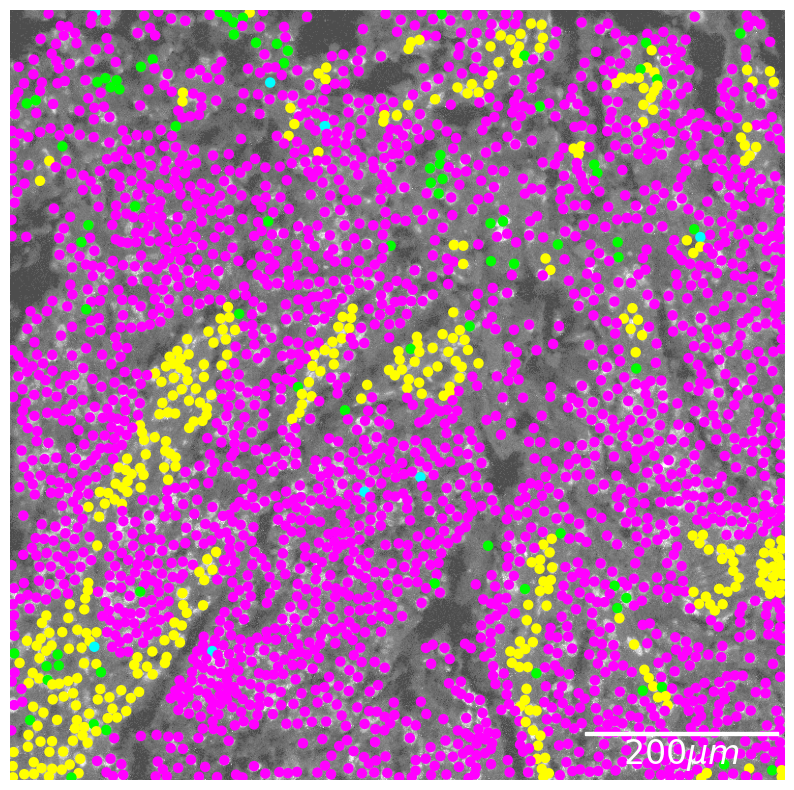

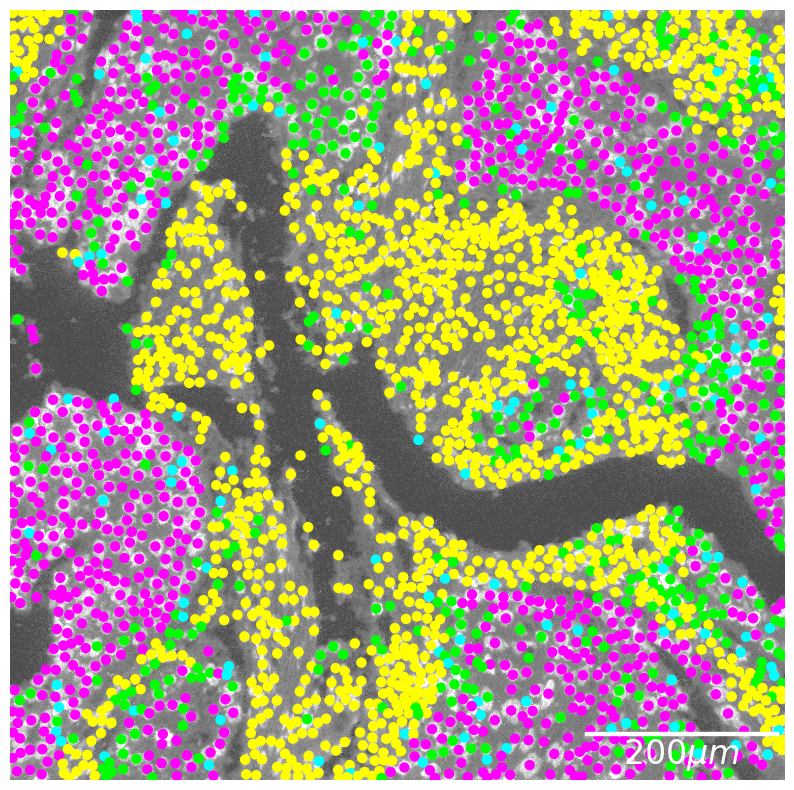

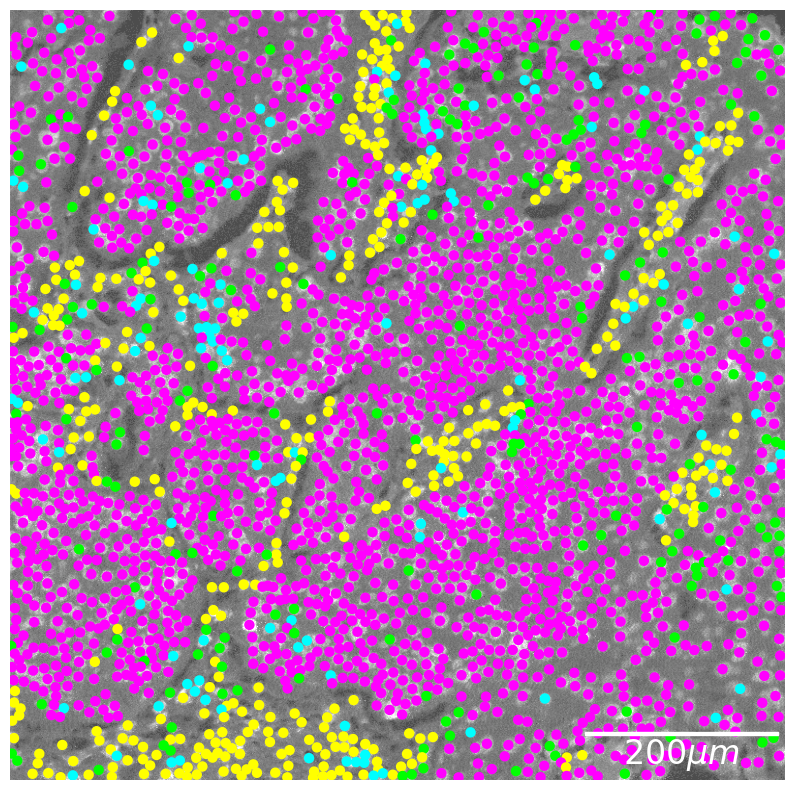

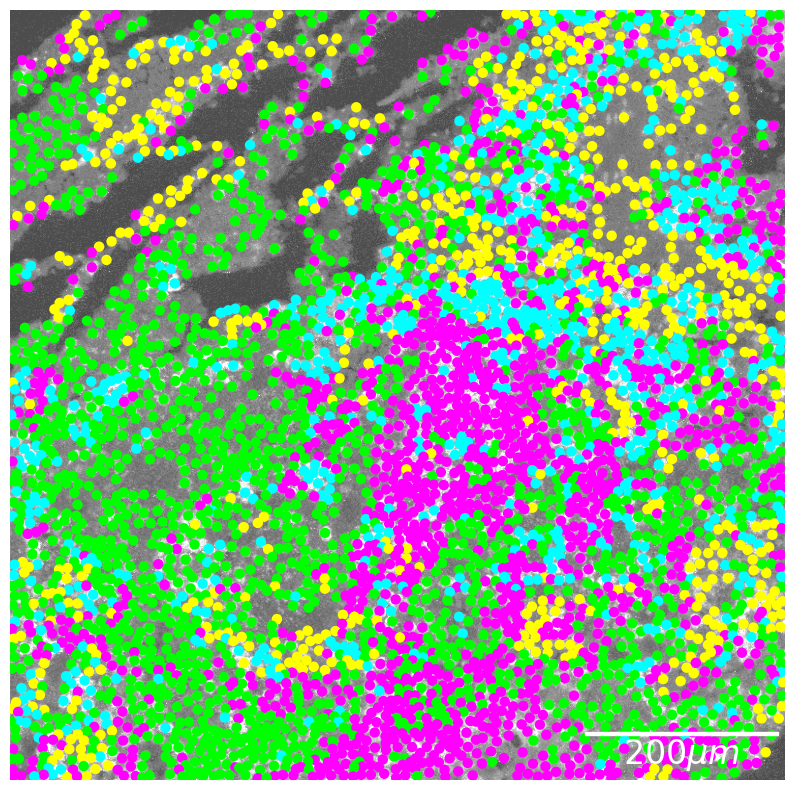

In [29]:
marker_list = [['ECadherin','PanKeratin'], ['CD68'],['CD8a'], ['Col1', 'SMA']]
labels = ['ECA+PanK', 'CD68', 'CD8a', 'Col1+SMA']
rgb = np.array([[255,0,255], [0,255,0], [0,255,255], [255,255,0], [160,160,160]])
mycmap = ListedColormap(rgb/255)
rgb2 = np.array([[255,51,255], [51,255,51], [0,0,255], [255,204,51], [160,160,160]])
mycmap2 = ListedColormap(rgb2/255)
scores = defaultdict(list)
scores_count = defaultdict(list)
show=True
n = 25

radius_list = [10, 20, 30, 40]

for dataset in datasets[:4]:

    # Read image and cell_mask
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    cell_mask = read_cell_mask(dataset)
    min_shape = min(cell_mask.shape[0], cell_mask.shape[1])
    min_shape = myround(min_shape, base=n)
    cell_mask = cell_mask[:min_shape, :min_shape]
    
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            if marker == 'CD8a':
                img = median(img, disk(1))
            p2, p98 = np.percentile(img, (0, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[:min_shape, :min_shape])
        imgs_list.append(np.array(np.mean(temp, axis=(0))))

    # Grayscale backgroun image
    avg_img = np.array(np.mean(imgs, axis=(0)))[:min_shape, :min_shape]
    
    df = get_cell_expression_level_mean(imgs_list, labels, cell_mask)
    df['ECA+PanK'] = df['ECA+PanK'] * 0.6
    node_class, node_colors = get_cell_color(df, labels, rgb)
    
    for r in radius_list[:1]:
    # Get cell neighbors analysis
        distances, neighbors, cell_labels, graph, X = get_distances(cell_mask, r=r)
        node_class, _ = get_cell_color(df, labels, rgb)

        #Plot proximity map
        fig, ax = plt.subplots(figsize=(10,10))
        ax.axis('off')
        top, right = avg_img.shape
        ax.imshow(imgs[-2][:min_shape, :min_shape], cmap='gray', alpha=0.7, aspect='auto', extent=[0,right,0,top], origin='lower')
        plot_nn(X, graph, node_colors, ax)
        ax.invert_yaxis()
#         color_text(0.3, 1, ax, f'Radius r = {r}', 'white', fontsize=35, fontweight='bold') 
        scalebar = AnchoredSizeBar(ax.transData,
                               200, r'$200  \mu m$', 'lower right', 
                               pad=0.1,
                               color='white',
                               frameon=False,
                               size_vertical=3,
                               fontproperties=fontprops)

        ax.add_artist(scalebar)
    plt.show()

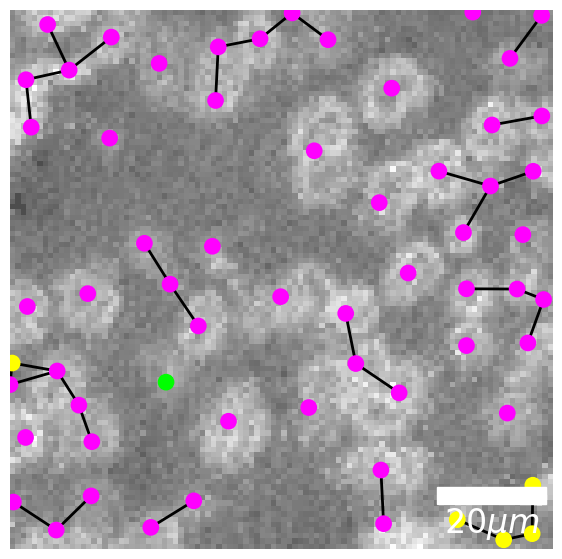

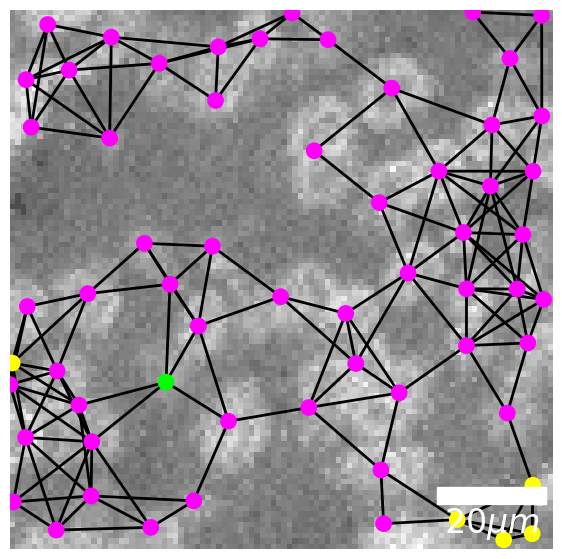

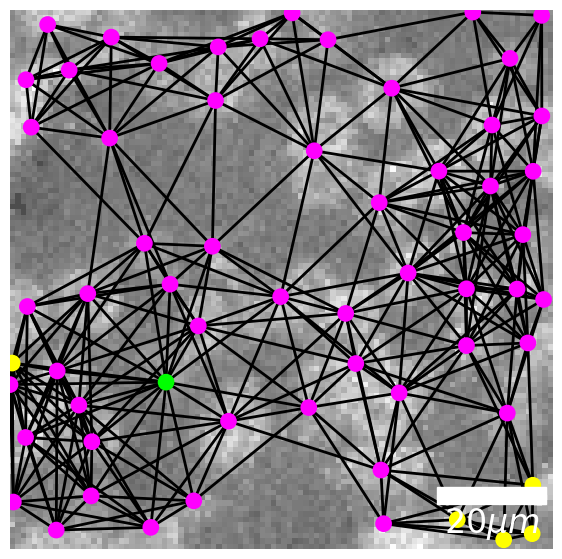

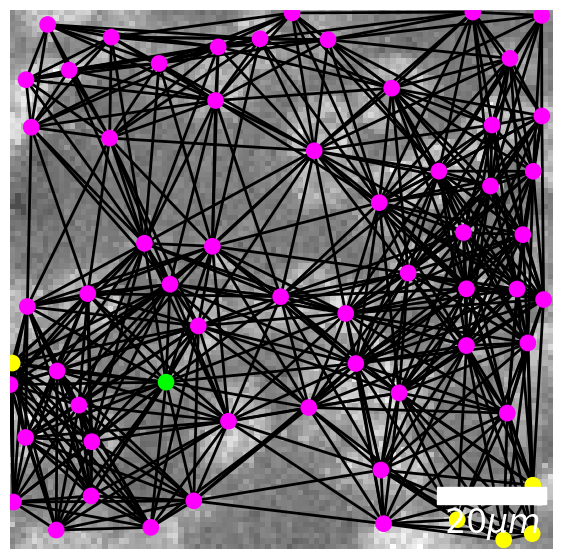

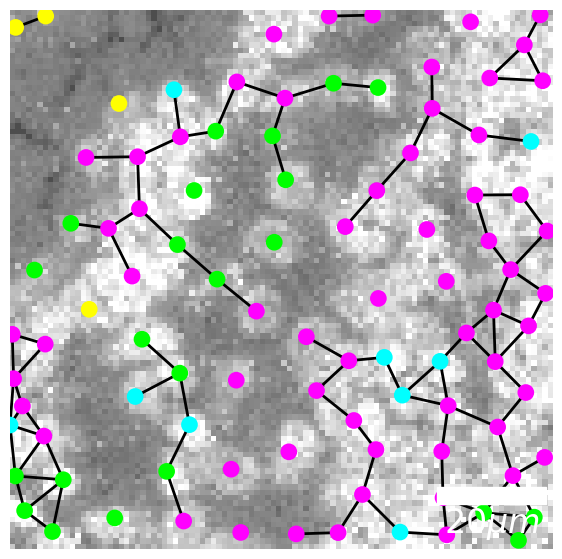

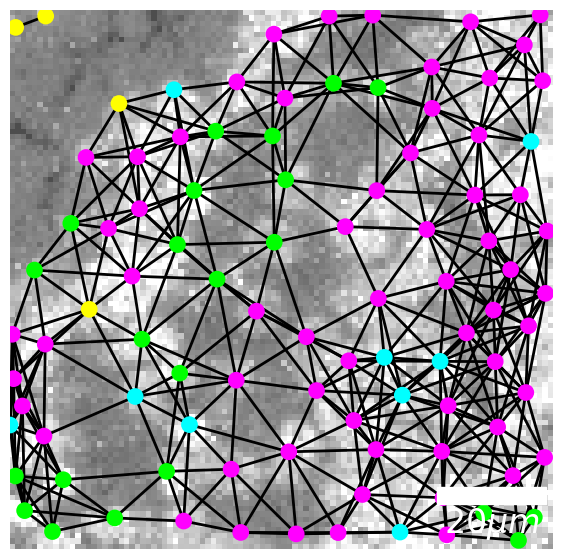

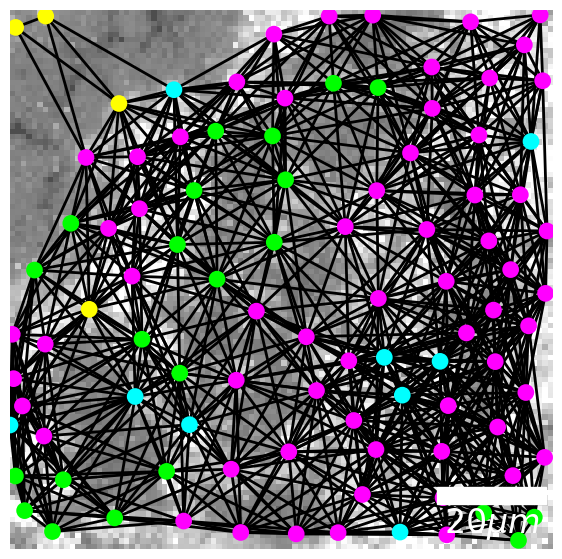

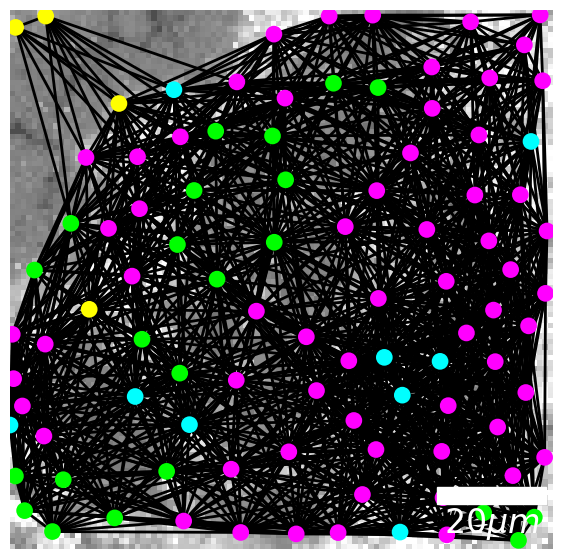

In [32]:
marker_list = [['ECadherin','PanKeratin'], ['CD68'],['CD8a'], ['Col1', 'SMA']]
labels = ['ECA+PanK', 'CD68', 'CD8a', 'Col1+SMA']
rgb = np.array([[255,0,255], [0,255,0], [0,255,255], [255,255,0], [160,160,160]])
mycmap = ListedColormap(rgb/255)
rgb2 = np.array([[255,51,255], [51,255,51], [0,0,255], [255,204,51], [160,160,160]])
mycmap2 = ListedColormap(rgb2/255)
scores = defaultdict(list)
scores_count = defaultdict(list)
show=True
n = 25

radius_list = [10, 20, 30, 40]

for dataset in datasets[2:4]:

    # Read image and cell_mask
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    cell_mask = read_cell_mask(dataset)
    max_shape = 450 
    min_shape = 350
    cell_mask = cell_mask[min_shape: max_shape, min_shape:max_shape]
    
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            if marker == 'CD8a':
                img = median(img, disk(1))
            p2, p98 = np.percentile(img, (0, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[min_shape: max_shape, min_shape:max_shape])
        imgs_list.append(np.array(np.mean(temp, axis=(0))))

    # Grayscale backgroun image
    avg_img = np.array(np.mean(imgs, axis=(0)))[min_shape: max_shape, min_shape:max_shape]
    
    df = get_cell_expression_level_mean(imgs_list, labels, cell_mask)
    df['ECA+PanK'] = df['ECA+PanK'] * 0.6
    node_class, node_colors = get_cell_color(df, labels, rgb)
    
    for r in radius_list:
    # Get cell neighbors analysis
        distances, neighbors, cell_labels, graph, X = get_distances(cell_mask, r=r)
        node_class, _ = get_cell_color(df, labels, rgb)

        #Plot proximity map
        fig, ax = plt.subplots(figsize=(7,7))
        ax.axis('off')
        top, right = avg_img.shape
        ax.imshow(imgs[-2][min_shape: max_shape, min_shape:max_shape], cmap='gray', alpha=0.7, aspect='auto', extent=[0,right,0,top], origin='lower')
        plot_nn(X, graph, node_colors, ax, node_size=100)
        ax.invert_yaxis()
        fontprops = fm.FontProperties(size=24)
        scalebar = AnchoredSizeBar(ax.transData,
                               20, r'$20  \mu m$', 'lower right', 
                               pad=0.1,
                               color='white',
                               frameon=False,
                               size_vertical=3,
                               fontproperties=fontprops)

        ax.add_artist(scalebar)
    plt.show()